In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
i = 0
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if i <=5:
            print(os.path.join(dirname, filename))
        i += 1
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cartoon/data/validation/conan/45.jpg
/kaggle/input/cartoon/data/validation/conan/56.jpg
/kaggle/input/cartoon/data/validation/conan/20.jpg
/kaggle/input/cartoon/data/validation/conan/48.png
/kaggle/input/cartoon/data/validation/conan/58.jpg
/kaggle/input/cartoon/data/validation/conan/6.jpg


# Directory Mapping

In [4]:
train_dir = '/kaggle/input/cartoon/data/train'
test_dir = '/kaggle/input/cartoon/data/test'
valid_dir = '/kaggle/input/cartoon/data/validation'


train_conan = os.listdir('/kaggle/input/cartoon/data/train/conan')
print ('total training conan images',len(train_conan))
test_conan = os.listdir('/kaggle/input/cartoon/data/test/conan')
print ('total testing conan images',len(test_conan))
valid_conan = os.listdir('/kaggle/input/cartoon/data/validation/conan')
print ('total validation conan images',len(valid_conan))


train_shinchan = os.listdir('/kaggle/input/cartoon/data/train/shinchan')
print ('total training shinchan images',len(train_shinchan))
test_shinchan = os.listdir('/kaggle/input/cartoon/data/test/shinchan')
print ('total testing shinchan images',len(test_shinchan))
valid_shinchan = os.listdir('/kaggle/input/cartoon/data/validation/shinchan')
print ('total validation shinchan images',len(valid_shinchan))


total training conan images 525
total testing conan images 5
total validation conan images 88
total training shinchan images 521
total testing shinchan images 5
total validation shinchan images 102


# Image sampling

(874, 900, 3)


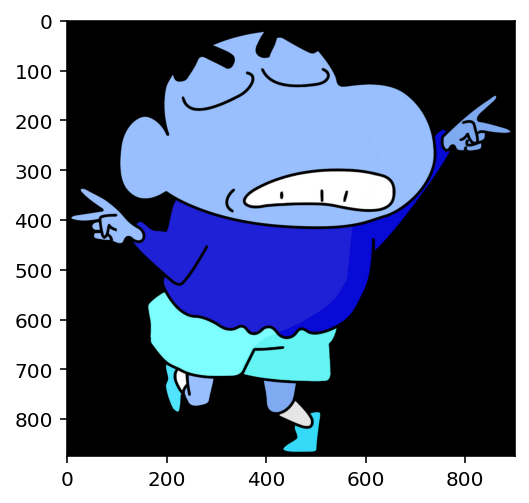

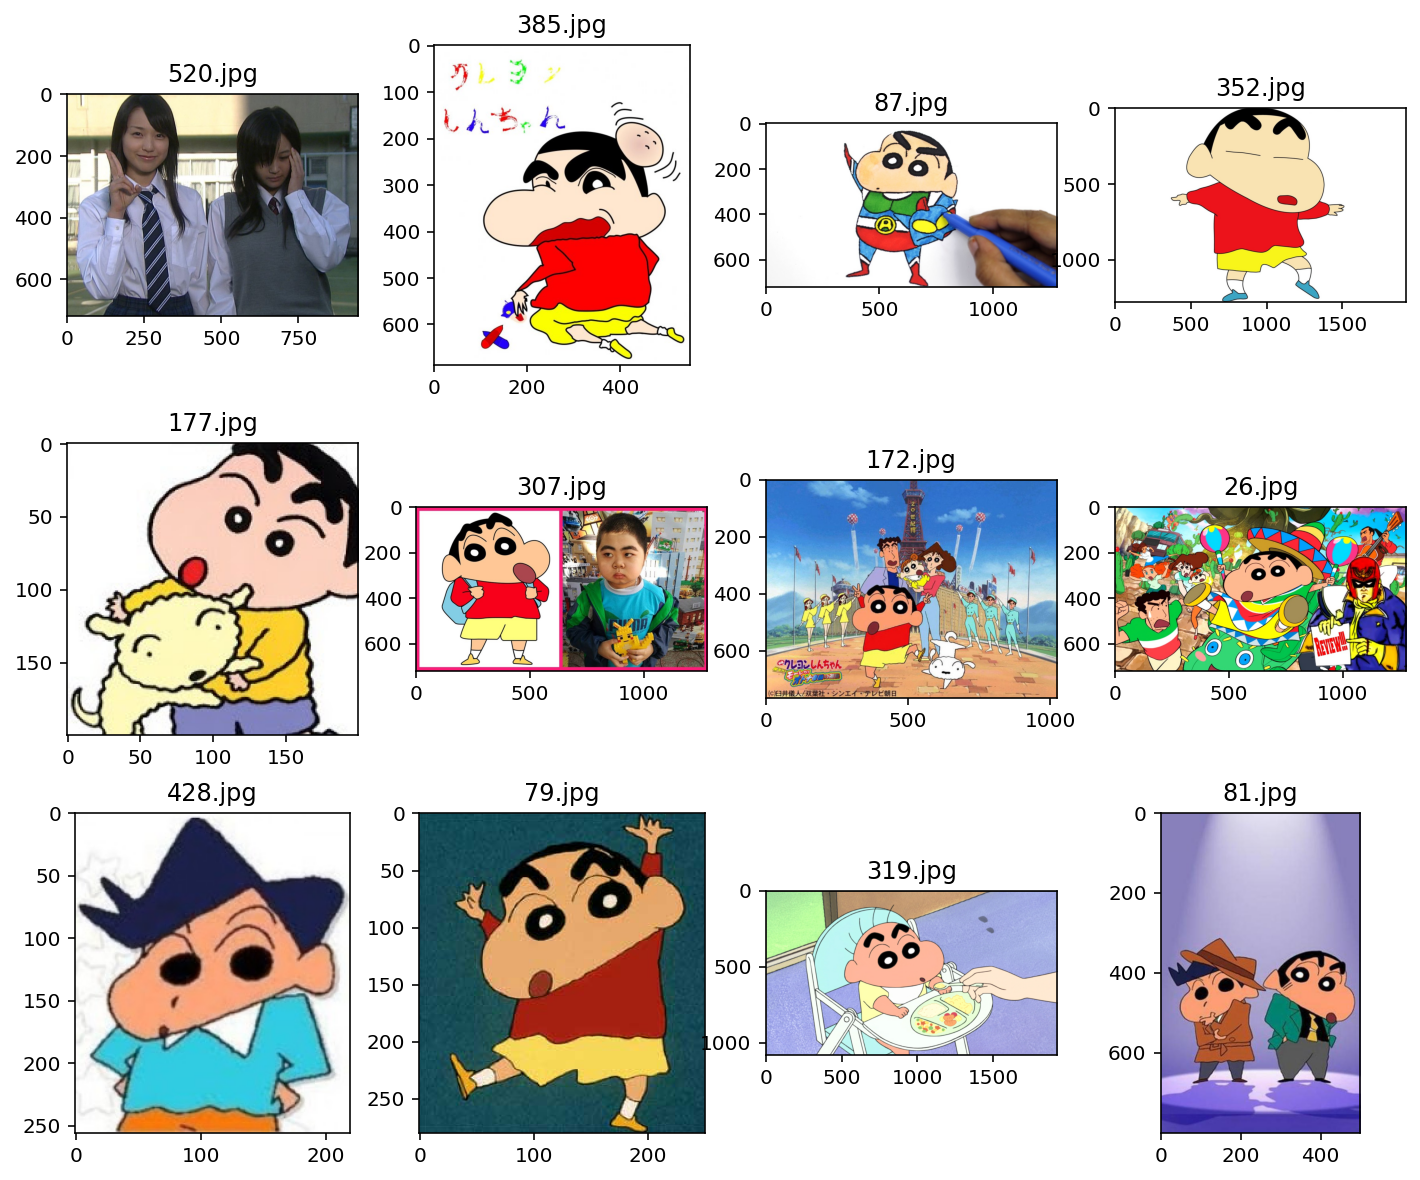

In [5]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cv2
img = cv2.imread('/kaggle/input/cartoon/data/train/shinchan/201.png')
print (img.shape)
plt.imshow(img)

plt.figure(figsize=(12,10))
path = '/kaggle/input/cartoon/data/train/shinchan'
filenames = os.listdir(path)
for i,filename in enumerate(random.sample(filenames,12)):
    plt.subplot(3,4,i+1)
    plt.imshow(cv2.imread(os.path.join(path,filename))[:,:,::-1])
    plt.title(filename)

In [11]:
print (os.getcwd())
path = 'cartoon_v1'
isFileExist = os.path.exists(path)
print (isFileExist)
if not isFileExist:
    os.makedirs(path)

/kaggle/working
True


# Image Resize

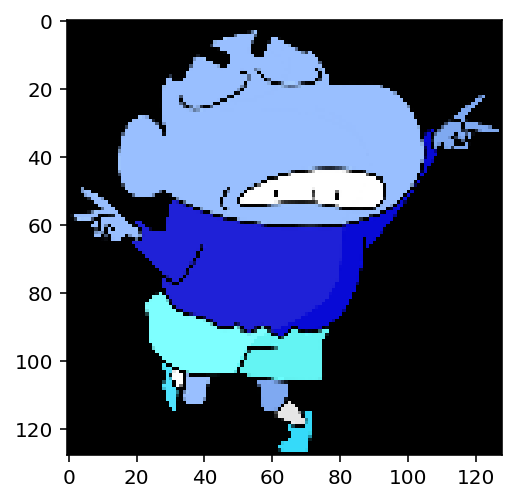

In [6]:
width = 128
x = cv2.resize(cv2.imread(os.path.join(path,'201.png')),(width,width))
plt.imshow(x)

# Building infrastructure of CNN

In [7]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Configuration of model for training

In [8]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

# ImageDataGenerator to read images

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical')


Found 2100 images belonging to 5 classes.
Found 340 images belonging to 5 classes.


In [10]:
for data_batch,labels_batch in train_generator:
    print ('data batch shape',data_batch.shape)
    print ('labels batch shape',labels_batch.shape)
    break

data batch shape (20, 150, 150, 3)
labels batch shape (20, 5)


# Train the Model

In [12]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=50,
                             epochs=30,
                             validation_data=valid_generator,
                             validation_steps=10)

Epoch 1/30
50/50 [==============================] - 29s 581ms/step - loss: 1.5710 - acc: 0.2042 - val_loss: 1.5056 - val_acc: 0.2000
Epoch 2/30
50/50 [==============================] - 23s 458ms/step - loss: 1.5333 - acc: 0.2014 - val_loss: 1.6209 - val_acc: 0.2000
Epoch 3/30
50/50 [==============================] - 20s 409ms/step - loss: 1.4652 - acc: 0.4132 - val_loss: 1.4286 - val_acc: 0.6610
Epoch 4/30
50/50 [==============================] - 20s 403ms/step - loss: 1.3838 - acc: 0.6522 - val_loss: 1.3666 - val_acc: 0.6160
Epoch 5/30
50/50 [==============================] - 18s 366ms/step - loss: 1.3261 - acc: 0.7088 - val_loss: 1.2611 - val_acc: 0.7160
Epoch 6/30
50/50 [==============================] - 18s 371ms/step - loss: 1.2656 - acc: 0.7654 - val_loss: 1.2622 - val_acc: 0.7500
Epoch 7/30
50/50 [==============================] - 19s 380ms/step - loss: 1.2146 - acc: 0.7854 - val_loss: 1.1578 - val_acc: 0.7780
Epoch 8/30
50/50 [==============================] - 18s 353ms/step - 

# Accuary and Loss curve

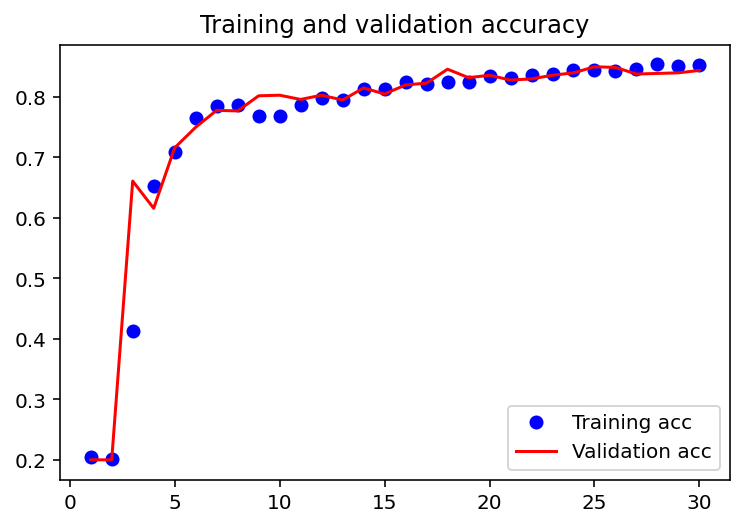

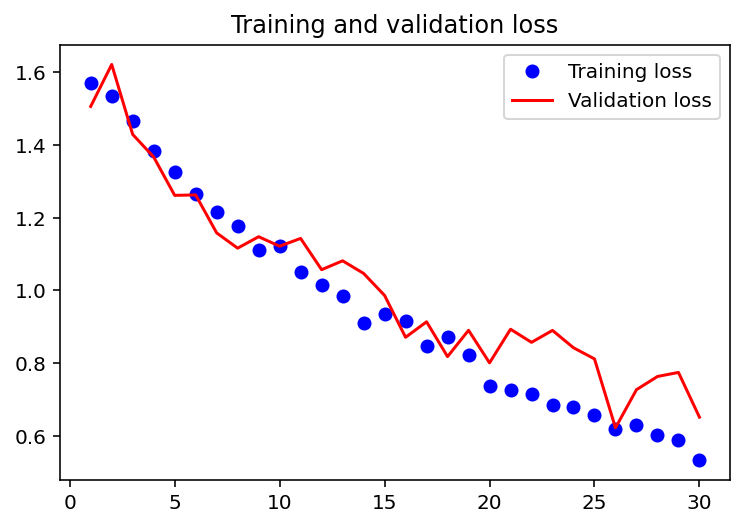

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Image Augumentation

In [15]:
datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

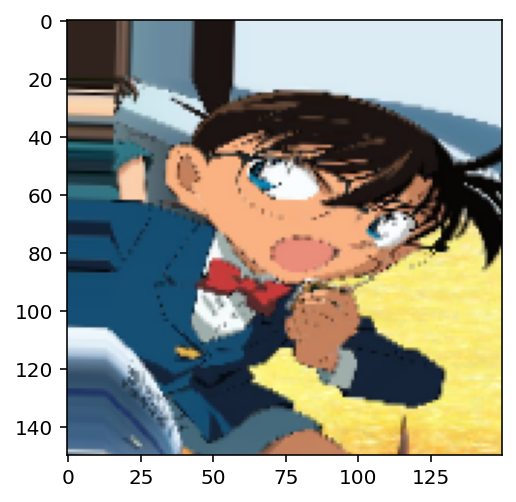

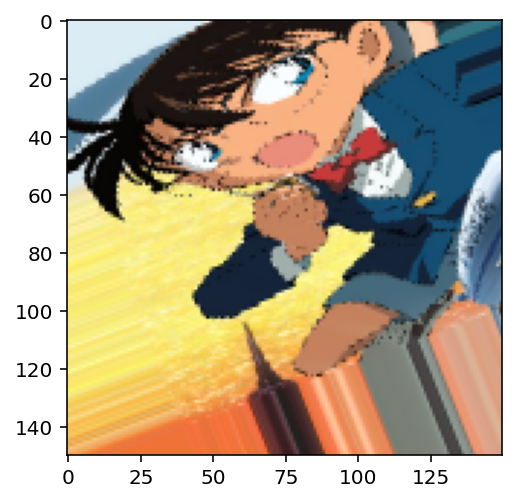

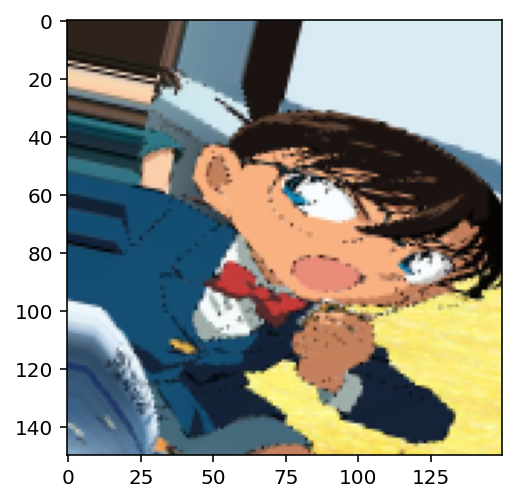

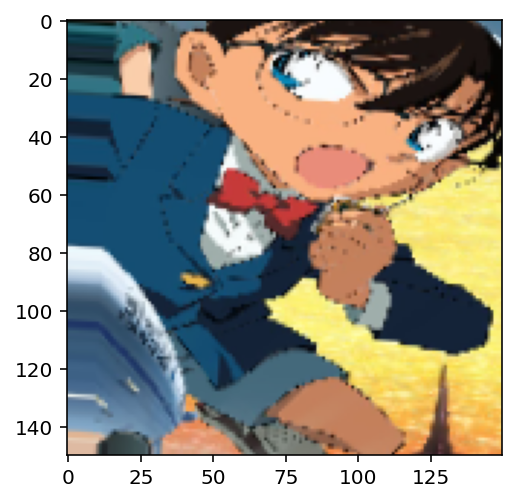

In [23]:
from keras.preprocessing import image
train_sample = '/kaggle/input/cartoon/data/train/conan'
fnames = [os.path.join(train_sample,fname) for fname in os.listdir(train_sample)]
img_path = fnames[10]
img = image.load_img(img_path,target_size=(150,150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x,batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i%4 == 0:
        break
plt.show()

# Retrain the model with augumented images

In [44]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))

model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

In [51]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   class_mode='categorical')


Found 2100 images belonging to 5 classes.
Found 340 images belonging to 5 classes.


In [52]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=50,
                             epochs=30,
                             validation_data=valid_generator,
                             validation_steps=10)

Epoch 1/30
50/50 [==============================] - 24s 487ms/step - loss: 1.5283 - acc: 0.7374 - val_loss: 1.4929 - val_acc: 0.7270
Epoch 2/30
50/50 [==============================] - 24s 473ms/step - loss: 1.4960 - acc: 0.7288 - val_loss: 1.4758 - val_acc: 0.7640
Epoch 3/30
50/50 [==============================] - 24s 489ms/step - loss: 1.4536 - acc: 0.7156 - val_loss: 1.4476 - val_acc: 0.7320
Epoch 4/30
50/50 [==============================] - 23s 467ms/step - loss: 1.4324 - acc: 0.7170 - val_loss: 1.3616 - val_acc: 0.7540
Epoch 5/30
50/50 [==============================] - 23s 463ms/step - loss: 1.3859 - acc: 0.7376 - val_loss: 1.3638 - val_acc: 0.7600
Epoch 6/30
50/50 [==============================] - 22s 449ms/step - loss: 1.3914 - acc: 0.7314 - val_loss: 1.3106 - val_acc: 0.7520
Epoch 7/30
50/50 [==============================] - 24s 490ms/step - loss: 1.3317 - acc: 0.7412 - val_loss: 1.3319 - val_acc: 0.7370
Epoch 8/30
50/50 [==============================] - 24s 480ms/step - 

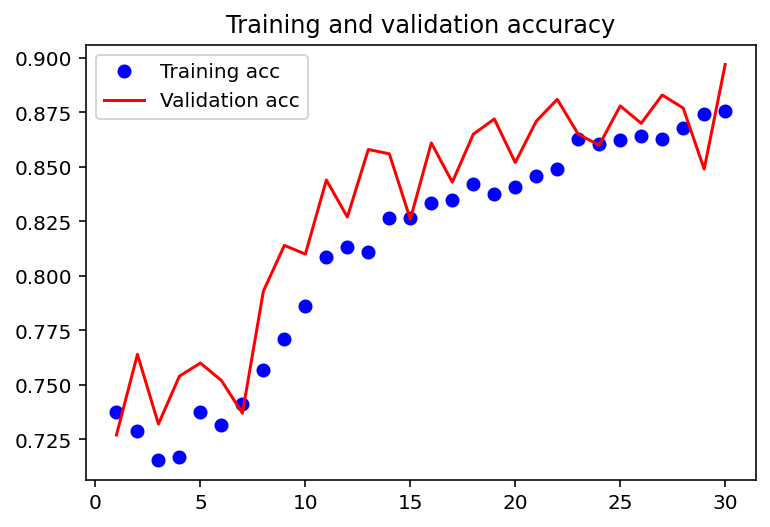

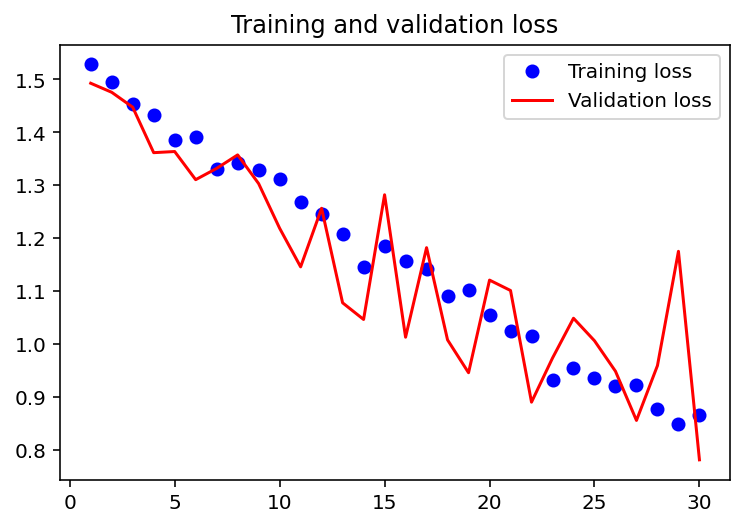

In [53]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()